In [1]:
from google.colab import drive
from google.colab import files
import pickle
import sys

sys.path.append('/content/gdrive/My Drive/classification_models')
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# %pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# from model_interface import prepare_data, train_model, model_metrics, get_predictions
# import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Activation, Dropout, Embedding, BatchNormalization, Input
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import sequence, text


from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import warnings
warnings.filterwarnings("ignore")

import random

from tqdm import tqdm
import matplotlib.cm as cm

tqdm.pandas()


from sklearn import metrics
from sklearn.utils import shuffle

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

import nltk

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)


def prepare_data(dataset, feature_column, target_column, return_test=False, max_len=None):
    if max_len is None:
        max_len = dataset[feature_column].apply(lambda x: len(str(x).split())).max()
    token = text.Tokenizer(num_words=None)
    if return_test:
        train, test = train_test_split(dataset, train_size=0.8, shuffle=True)
        train, validation = train_test_split(train, train_size=0.8, shuffle=True)
        xtrain = train[feature_column].values
        ytrain = train[target_column].values

        xvalid = validation[feature_column].values
        yvalid = validation[target_column].values

        xtest = test[feature_column].values
        ytest = test[target_column].values
        token.fit_on_texts(list(xtrain) + list(xvalid))

        xtrain_seq = token.texts_to_sequences(xtrain)
        xvalid_seq = token.texts_to_sequences(xvalid)

        xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
        xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

        xtest_seq = token.texts_to_sequences(xtest)
        xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

        word_index = token.word_index

        return (xtrain_pad, ytrain), (xvalid_pad, yvalid), (xtest_pad, ytest), word_index, max_len

    x = dataset[feature_column].values
    y = dataset[target_column].values
    token.fit_on_texts(list(x))
    x_seq = token.texts_to_sequences(x)
    x_pad = sequence.pad_sequences(x_seq, maxlen=max_len)
    word_index = token.word_index

    return (x_pad, y), word_index, max_len, token


def get_embedding_matrix(embeddings_index, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def train_model(xtrain, ytrain, len_word_index, max_len, strategy, weights=None, batch_size=16, epochs=5, threads=1, xvalid=None, yvalid=None):
    with strategy.scope():
        model = Sequential()
        if weights is not None:
            model.add(Embedding(len_word_index + 1,
                                300,
                                input_length=max_len,
                                weights=[weights],
                                trainable=False))
        else:
            model.add(Embedding(len_word_index + 1,
                                300,
                                input_length=max_len))
            
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
        model.add(Dropout(0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    if xvalid is not None and yvalid is not None:
        model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=epochs, batch_size=batch_size * threads)
    else:
        model.fit(xtrain, ytrain, epochs=epochs, batch_size=batch_size * threads)

    return model


def get_predictions(x, model, print_metrics=False, target=None):
    scores = model.predict(x)
    predictions = np.round(np.max(scores, axis=1))
    if print_metrics:
        fpr, tpr, thresholds = metrics.roc_curve(target, scores)
        roc_auc = metrics.auc(fpr, tpr)
        f1 = metrics.f1_score(target, predictions)
        accuracy = metrics.accuracy_score(target, predictions)
        print(f'Roc-Auc score: {roc_auc}')
        print(f'F1 score: {f1}')
        print(f'Accuracy: {accuracy}')
        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return predictions


def model_metrics(predictions, target):

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


In [3]:
import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    #tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.6.182.50:8470
REPLICAS:  8


In [4]:
toxic_dataset = pd.read_csv('/content/gdrive/My Drive/classification_models/toxic_tweets.csv', index_col=False)
# antivax_dataset = pd.read_csv('/content/gdrive/My Drive/classification_models/antivax_dataset.csv')

# antivax_dataset = antivax_dataset[~antivax_dataset['text'].isna()]
# antivax_dataset['anti_vax'] = antivax_dataset['anti_vax'].astype(int)

In [ ]:
print(toxic_dataset[toxic_dataset['Toxicity'] == 1]['tweet'][:100].values)

["@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  "
 'no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins'
 'retweet if you agree! '
 '@user @user lumpy says i am a . prove it lumpy.'
 "it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia "
 '@user lets fight against  #love #peace '
 "ð\x9f\x98©the white establishment can't have blk folx running around loving themselves and promoting our greatness  "
 "@user hey, white people: you can call people 'white' by @user  #race  #identity #medâ\x80¦"
 'how the #altright uses  &amp; insecurity to lure men into #whitesupremacy    '
 "@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ\x80¦"
 '@user why not @user mocked obama for being black.  @user @user @user @user #brexit'
 "#people aren't protesting #trump because a #republican won-they do so 

In [ ]:
(toxic_features, toxic_target), toxic_word_index, toxic_max_len, toxic_token = prepare_data(toxic_dataset,
                                                                                            feature_column='tweet', 
                                                                                            target_column='Toxicity',
                                                                                            return_test=False,
                                                                                            max_len=100)

In [ ]:
(antivax_features, antivax_target), antivax_word_index, antivax_max_len, antivax_token = prepare_data(antivax_dataset,
                                                                                                      feature_column='text', 
                                                                                                      target_column='anti_vax',
                                                                                                      return_test=False,
                                                                                                      max_len=100)

In [5]:
(toxic_xtrain, toxic_ytrain), (toxic_xvalid, toxic_yvalid), (toxic_xtest, toxic_ytest), toxic_word_index, toxic_max_len = prepare_data(toxic_dataset, 
                                                                                                                          feature_column='tweet', 
                                                                                                                          target_column='Toxicity',
                                                                                                                          return_test=True,
                                                                                                                          max_len=100)

# (antivax_xtrain, antivax_ytrain), (antivax_xvalid, antivax_yvalid), (antivax_xtest, antivax_ytest), antivax_word_index, antivax_max_len = prepare_data(antivax_dataset, 
#                                                                                        feature_column='text', 
#                                                                                        target_column='anti_vax',
#                                                                                        return_test=True,
#                                                                                        max_len=100)


In [ ]:
embeddings_index = {}
f = open('/content/gdrive/My Drive/classification_models/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
toxic_embedding_matrix = np.zeros((len(toxic_word_index) + 1, 300))
for word, i in tqdm(toxic_word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        toxic_embedding_matrix[i] = embedding_vector

100%|██████████| 62335/62335 [00:00<00:00, 177231.88it/s]


In [ ]:
toxic_model = train_model(toxic_features, toxic_target, 
                          len_word_index=len(toxic_word_index), 
                          max_len=toxic_max_len,
                          strategy=strategy,
                          threads=strategy.num_replicas_in_sync,
                          batch_size=16)

Epoch 1/5
444/444 [==============================] - 63s 100ms/step - loss: 0.1915 - accuracy: 0.9233
Epoch 2/5
444/444 [==============================] - 36s 81ms/step - loss: 0.0577 - accuracy: 0.9797
Epoch 3/5
444/444 [==============================] - 38s 85ms/step - loss: 0.0177 - accuracy: 0.9939
Epoch 4/5
444/444 [==============================] - 37s 83ms/step - loss: 0.0067 - accuracy: 0.9980
Epoch 5/5
444/444 [==============================] - 35s 78ms/step - loss: 0.0038 - accuracy: 0.9989


In [ ]:
antivax_model = train_model(antivax_features, antivax_target,
                            len_word_index=len(antivax_word_index), 
                            max_len=antivax_max_len,
                            strategy=strategy,
                            threads=strategy.num_replicas_in_sync,
                            batch_size=16,
                            epochs=5)

Epoch 1/5
579/579 [==============================] - 77s 97ms/step - loss: 0.2866 - accuracy: 0.8776
Epoch 2/5
579/579 [==============================] - 46s 79ms/step - loss: 0.1387 - accuracy: 0.9468
Epoch 3/5
579/579 [==============================] - 46s 80ms/step - loss: 0.0800 - accuracy: 0.9688
Epoch 4/5
579/579 [==============================] - 46s 79ms/step - loss: 0.0517 - accuracy: 0.9798
Epoch 5/5
579/579 [==============================] - 46s 80ms/step - loss: 0.0377 - accuracy: 0.9851


In [ ]:
from tensorflow.keras.saving import save_model

# save_model(toxic_model, '/content/gdrive/My Drive/classification_models/toxic_model')
save_model(antivax_model, '/content/gdrive/My Drive/classification_models/antivax_model')

In [7]:
toxic_model = train_model(toxic_xtrain, toxic_ytrain, 
                          len_word_index=len(toxic_word_index), 
                          # weights = toxic_embedding_matrix,
                          max_len=toxic_max_len,
                          strategy=strategy,
                          xvalid=toxic_xvalid, yvalid=toxic_yvalid, threads=strategy.num_replicas_in_sync)

Epoch 1/5
284/284 [==============================] - 55s 129ms/step - loss: 0.2220 - accuracy: 0.9073 - val_loss: 0.3906 - val_accuracy: 0.7900
Epoch 2/5
284/284 [==============================] - 24s 85ms/step - loss: 0.0634 - accuracy: 0.9781 - val_loss: 0.1981 - val_accuracy: 0.9358
Epoch 3/5
284/284 [==============================] - 23s 79ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.2629 - val_accuracy: 0.9349
Epoch 4/5
284/284 [==============================] - 23s 80ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.3297 - val_accuracy: 0.9308
Epoch 5/5
284/284 [==============================] - 23s 81ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.3702 - val_accuracy: 0.9343


In [ ]:
antivax_embedding_matrix = np.zeros((len(antivax_word_index) + 1, 300))
for word, i in tqdm(antivax_word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        antivax_embedding_matrix[i] = embedding_vector

100%|██████████| 82681/82681 [00:00<00:00, 210992.29it/s]


In [ ]:
antivax_model = train_model(antivax_xtrain, 
                            antivax_ytrain, 
                            len_word_index=len(antivax_word_index), 
                            max_len=antivax_max_len,
                            strategy=strategy,
                            weights=antivax_embedding_matrix,
                            xvalid=antivax_xvalid, yvalid=antivax_yvalid, threads=strategy.num_replicas_in_sync)

Epoch 1/5
371/371 [==============================] - 54s 99ms/step - loss: 0.3602 - accuracy: 0.8433 - val_loss: 0.3280 - val_accuracy: 0.8702
Epoch 2/5
371/371 [==============================] - 27s 72ms/step - loss: 0.2687 - accuracy: 0.8893 - val_loss: 0.2725 - val_accuracy: 0.8876
Epoch 3/5
371/371 [==============================] - 27s 72ms/step - loss: 0.2343 - accuracy: 0.9044 - val_loss: 0.2767 - val_accuracy: 0.8931
Epoch 4/5
371/371 [==============================] - 26s 71ms/step - loss: 0.2082 - accuracy: 0.9146 - val_loss: 0.2578 - val_accuracy: 0.8976
Epoch 5/5
371/371 [==============================] - 27s 73ms/step - loss: 0.1876 - accuracy: 0.9244 - val_loss: 0.2590 - val_accuracy: 0.8988


355/355 [==============================] - 6s 15ms/step
Roc-Auc score: 0.9797315350684028
F1 score: 0.9302086545379792
Accuracy: 0.9401709401709402


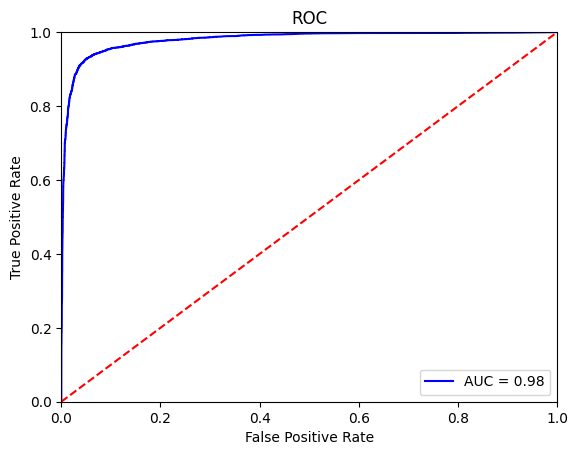

array([0., 1., 1., ..., 1., 0., 0.], dtype=float32)

In [11]:
get_predictions(toxic_xtest, toxic_model, print_metrics=True, target=toxic_ytest)

In [ ]:
predictions = get_predictions(antivax_xtest, antivax_model, print_metrics=True, target=antivax_ytest)

463/463 [==============================] - 11s 19ms/step
Roc-Auc score: 0.9648682776748614
F1 score: 0.8910102224894769
Accuracy: 0.9020733436887959


In [ ]:
with open('/content/gdrive/My Drive/classification_models/replies_clusters_with_datetime.pickle', 'rb') as f:
    replies_clusters = pickle.load(f)

In [ ]:
replies_clusters['cleaned_tweet'].values

6                               vaccination dangers health
8        sharp end of vaccination the daily telegraph b...
7        the sharp end of vaccination gets served the c...
5        flu vaccination event raises more than k for c...
4        flu vaccination programme for pregnant women u...
                               ...                        
48602    you are lying i live in eu we have mandatory v...
48603    you as declared leftist probably support depop...
48605    no it s not proven vaccination is just product...
48609    he is the president that bailed out vaccinatio...
48613    day hi love hope your day went well baby sorry...
Name: cleaned_tweet, Length: 48619, dtype: object

In [ ]:
def get_tokens(data, token, max_len=100):
    x_seq = token.texts_to_sequences(data)
    x_pad = sequence.pad_sequences(x_seq, maxlen=max_len)
    return x_pad

In [ ]:
tweets_toxic_pad = get_tokens(replies_clusters['cleaned_tweet'].values, toxic_token)
tweets_antivax_pad = get_tokens(replies_clusters['cleaned_tweet'].values, antivax_token)

In [ ]:
toxic_predictions = get_predictions(tweets_toxic_pad, toxic_model, print_metrics=False)
antivax_predictions = get_predictions(tweets_antivax_pad, antivax_model, print_metrics=False)

1520/1520 [==============================] - 27s 17ms/step


In [ ]:
sum(antivax_predictions)

42064.0

In [ ]:
toxic_tokens_empty = [0] * len(tweets_toxic_pad)
antivax_tokens_empty = [0] * len(tweets_toxic_pad)

for i, tok in enumerate(tweets_toxic_pad):
    if sum(tok) == 0:
        toxic_tokens_empty[i] = 1

for i, tok in enumerate(tweets_antivax_pad):
    if sum(tok) == 0:
        antivax_tokens_empty[i] = 1

In [ ]:
replies_clusters['toxic_prediction'] = toxic_predictions
replies_clusters['antivax_prediction'] = antivax_predictions

replies_clusters['toxic_tokens_empty'] = toxic_tokens_empty
replies_clusters['antivax_tokens_empty'] = antivax_tokens_empty

In [ ]:
replies_clusters['toxic_prediction'] = replies_clusters['toxic_prediction'].astype(int)
replies_clusters['antivax_prediction'] = replies_clusters['antivax_prediction'].astype(int)

In [ ]:
with open('/content/gdrive/My Drive/classification_models/replies_clusters_with_predicitons.pickle', 'wb') as f:
    pickle.dump(replies_clusters, f)

In [ ]:
replies_clusters

,conversation_id,user_id,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,reply_to,...,embeddings_pca,embeddings_tsne,avg_embedding_pca,avg_embedding_tsne,tweets_cluster,datetime,toxic_prediction,antivax_prediction,toxic_tokens_empty,antivax_tokens_empty
6,1030000000000000,15628274,drbloem,Vaccination Dangers http://bit.ly/54oEjD #health,[],0,0,0,['#health'],"[{'user_id': '15628274', 'username': 'drbloem'}]",...,"[0.089807294, -0.076945916, -0.060742203, -0.0...","[-6.5955834, -0.24445535]","[3.2530833890231343, -3.8364880767818645, -2.2...","[-3.920255, 6.8469424]",0,2010-01-01 03:03:23,0,1,0,0
8,1030000000000000,88865710,reasonable_hank,Sharp end of vaccination | The Daily Telegraph...,['nocompulsoryvac'],0,0,0,"['#stopavn', '#vaxfax', '#1sol', '#vaccinetimes']","[{'user_id': '88865710', 'username': 'reasonab...",...,"[0.033905577, 0.08001816, 0.15066516, 0.076626...","[9.261212, 13.295772]","[-3.9778080080169658, -1.2387839170417985, 3.2...","[-28.207369, 7.776887]",0,2010-11-07 00:36:02,0,1,0,0
7,1030000000000000,17887403,happysinger,The Sharp End of Vaccination: @nocompulsoryvac...,['nocompulsoryvac'],0,11,1,"['#stopavn', '#skeptics']","[{'user_id': '17887403', 'username': 'HappySin...",...,"[-0.0499199, -0.034067053, -0.027884655, -0.14...","[6.424397, 16.822279]","[-4.79636196862201, 0.17660501149269758, 2.510...","[-28.388243, 7.0919704]",0,2010-11-07 01:06:36,0,1,0,0
5,1120000000000000,79896423,constanthealth,Flu vaccination event raises more than $24K fo...,[],0,0,0,[],"[{'user_id': '79896423', 'username': 'constant...",...,"[-0.050425336, -0.13559175, 0.050015662, 0.127...","[28.01074, -12.579171]","[-1.3124122646398337, -0.35740021322966625, 0....","[1.8229796, -14.62932]",2,2010-11-07 06:50:01,0,0,0,0
4,1180000000000000,67735456,superdave009,Flu vaccination programme for pregnant women u...,[],0,0,0,[],"[{'user_id': '67735456', 'username': 'SUPERDAV...",...,"[0.08692184, -0.136391, 0.0139097655, 0.196331...","[29.058771, -24.126238]","[-0.8337440585171392, 0.8233614155332241, -0.1...","[1.9250319, -14.756243]",2,2010-11-07 11:11:34,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48602,1080000000000000000,47074030,lecterro,You are lying. I live in EU we have mandatory ...,"['sciarpuccio', 'thedarklander', 'customdeluxe...",2,0,0,[],"[{'user_id': '47074030', 'username': 'lecterro...",...,"[0.05201471, 0.044375177, -0.09976234, 0.09072...","[-21.607311, -15.356277]","[-0.5615677590726315, -1.3629824259284742, -2....","[-16.840807, 4.265732]",0,2019-04-09 09:34:55,0,1,0,0
48603,1080000000000000000,47074030,lecterro,You as declared leftist probably support depop...,"['sciarpuccio', 'thedarklander', 'customdeluxe...",0,0,0,[],"[{'user_id': '47074030', 'username': 'lecterro...",...,"[-0.045209162, -0.039129417, -0.122394286, -0....","[-18.350245, 6.1286597]","[-0.5615677590726315, -1.3629824259284742, -2....","[-16.840807, 4.265732]",0,2019-04-12 17:54:23,0,1,0,0
48605,1080000000000000000,47074030,lecterro,"No, it's not proven. Vaccination is just produ...","['sciarpuccio', 'customdeluxe79', 'thedarkland...",3,0,0,[],"[{'user_id': '47074030', 'username': 'lecterro...",...,"[-0.035899732, -0.08410108, -0.08765227, -0.04...","[-7.565072, 10.097867]","[-0.5615677590726315, -1.3629824259284742, -2....","[-16.840807, 4.265732]",0,2019-04-16 22:24:23,0,1,0,0
48609,1080000000000000000,861000000000000000,patriciamspenc2,He is the President that bailed out vaccinatio...,"['iamthewatchman3', 'craigrsawyer']",0,0,0,[],"[{'user_id': '860595938204819458', 'username':...",...,"[-0.05483665, -0.045734424, -0.07168237, -0.14...","[-17.665083, 15.848436]","[7.105819932914268, 0.12631774595847284, -0.44...","[30.488146, 0.9783122]",1,2019-06-11 18:00:04,1,1,0,0
